Tasks:  
1.Analyze the results of the A/B testing between Group 2 and Group 1
Group 2 use a new algorithm that expected to increase the CTR, while Group 1 serves as the control group.  
2.Apply different methods, control and describe the results, suggest recommendation for the algorithm.

Main hypotheses:  
HO: The algorithm does not affect CTR.  
H1: The algorithm does affect CTR.

# A/B test analysis

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse 
%matplotlib inline

In [3]:
connection = {'host': '***',
                      'database':'***',
                      'user':'***', 
                      'password':'***'
                     }

In [4]:
#creating a functionn to simplify the workflow
def select(sql):
    
    table = pandahouse.read_clickhouse(sql, connection=connection)
    return table

In [5]:
#extracting the data and save it to a dataset.
sql = '''

SELECT user_id, 
        exp_group,
        countIf(action, action='like') as likes,
        countIf(action, action='view') as views,
        countIf(action, action='like') / countIf(action, action='view') as ctr        
FROM {db}.feed_actions 
WHERE exp_group in (1,2)  AND 
                        (toDate(time) >= '2023-04-01' and toDate(time) <= '2023-04-07' )
GROUP BY user_id, 
         exp_group
ORDER BY 1

'''

groups = select(sql)
groups.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750


In [6]:
groups[groups.exp_group == 2].ctr.mean(), groups[groups.exp_group == 1].ctr.mean()

(0.21441927347479375, 0.21560459841296287)

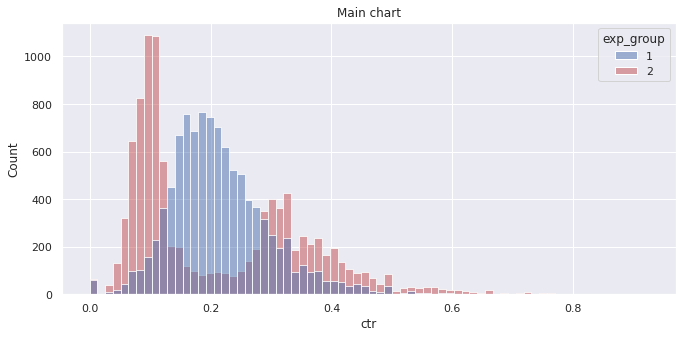

In [7]:
sns.set(rc={'figure.figsize': (11, 5)})
groups_graph = sns.histplot(data=groups , 
                                x='ctr', 
                                hue='exp_group',
                                palette=['b', 'r'],
                                alpha=0.5,
                                kde=False).set(title='Main chart')

On the main chart, it can be observed that there are differences between two groups. The CTR graph of the first group has unimodal (almost normal) distribution, while the CTR graph of the second group shows a bimodal distribution.
According to theory, applying a t-test in such case would have unreliable results (but I performed it to show you an example).

## 1.t-test

In [51]:
stats.ttest_ind(groups[groups.exp_group == 2].ctr,
                groups[groups.exp_group == 1].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935)

The results of the t-test indicate that there are no statistically significant differences. We cannot be confident that the groups differ from each other,   
therefore, there is no evidence to reject the null hypothesis (H0).

## 2.Mann–Whitney U test

In [52]:
stats.mannwhitneyu(groups[groups.exp_group == 2].ctr,
                    groups[groups.exp_group == 1].ctr,
                    alternative='two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

The Mann-Whitney test indicates that the differences between the groups are statistically significant.

## 3.Smoothed CTR method

In [53]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [54]:
global_ctr_1 = groups[groups.exp_group == 2].likes.sum()/groups[groups.exp_group == 2].views.sum()
global_ctr_2 = groups[groups.exp_group == 1].likes.sum()/groups[groups.exp_group == 1].views.sum()

In [55]:
group1 = groups[groups.exp_group == 1].copy()
group2 = groups[groups.exp_group == 2].copy()

group1['smothed_ctr'] = groups.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smothed_ctr'] = groups.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)



In [56]:
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=0.8022146784040156, pvalue=0.42244087372344064)

The differences between the groups are not considered statistically significant as the p-value is greater than 0.05.

### A graph of the normal(not-smoothed CTR) (Click-Through Rate).

[Text(0.5, 1.0, 'Group 1')]

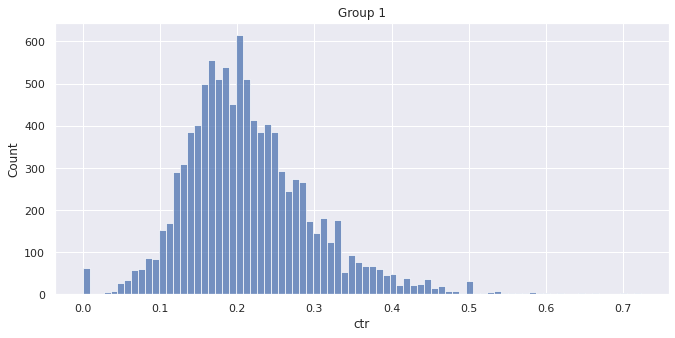

In [74]:
sns.histplot(group1.ctr,
             kde=False).set(title='Group 1')

[Text(0.5, 1.0, 'Group 2')]

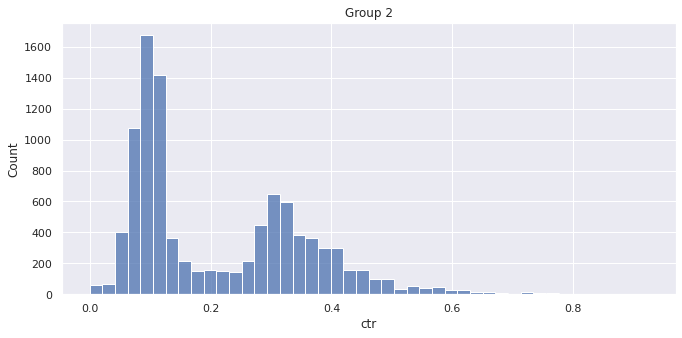

In [75]:
sns.histplot(group2.ctr,
             kde=False).set(title='Group 2')

### A graph of the smoothed CTR

[Text(0.5, 1.0, 'Group 1 smoothed')]

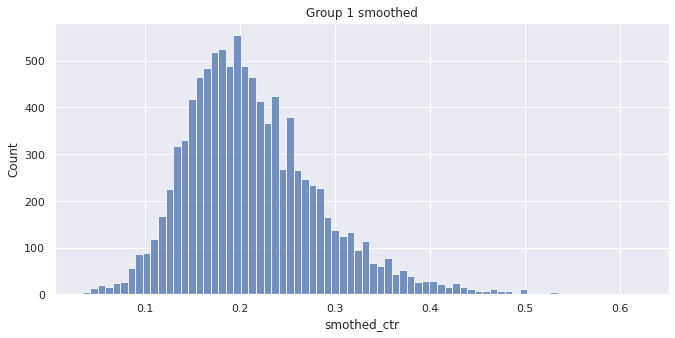

In [76]:
sns.histplot(group1.smothed_ctr,
             kde=False).set(title='Group 1 smoothed')

[Text(0.5, 1.0, 'Group 2 smoothed')]

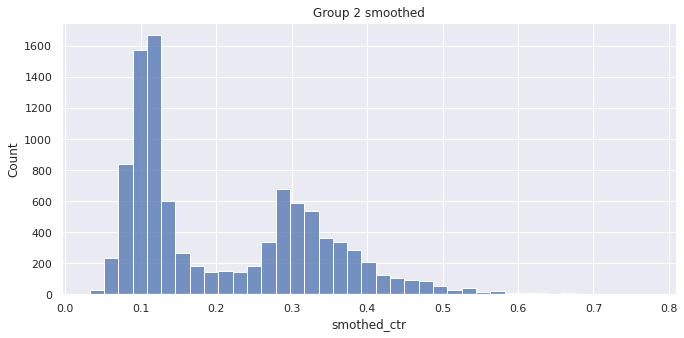

In [77]:
sns.histplot(group2.smothed_ctr,
             kde=False).set(title='Group 2 smoothed')

Based on the graphs, it can be seen that after applying the "smoothing" method, the graphs have been slightly adjusted.

## 4.Poisson bootstrap

In [32]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [33]:
likes1 = groups[groups.exp_group == 1].likes.to_numpy()
views1 = groups[groups.exp_group == 1].views.to_numpy()
likes2 = groups[groups.exp_group == 2].likes.to_numpy()
views2 = groups[groups.exp_group == 2].views.to_numpy()

In [34]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

[Text(0.5, 1.0, 'Group 1 & Group 2 CTR')]

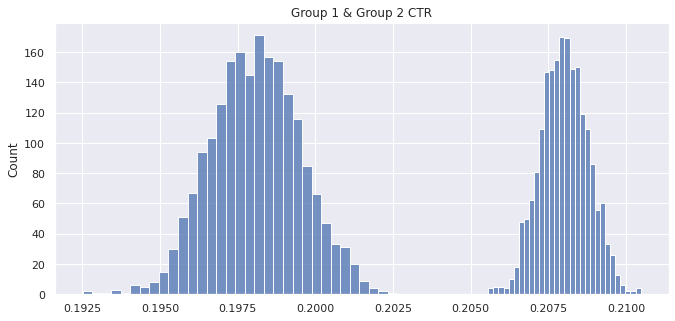

In [78]:
sns.histplot(ctr1).set(title='Group 1 & Group 2 CTR')
sns.histplot(ctr2).set(title='Group 1 & Group 2 CTR')

### Distribution of CTR

[Text(0.5, 1.0, 'Group 1 & Group 2 CTR Differences')]

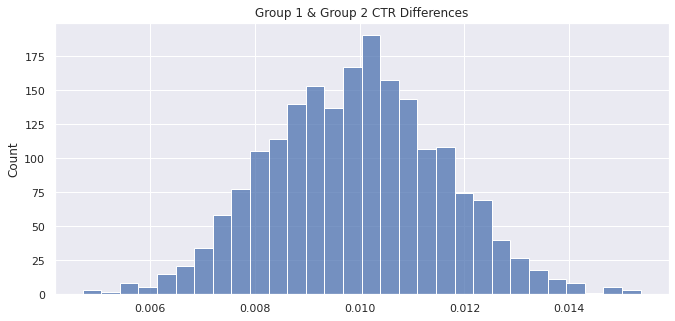

In [79]:
sns.histplot(ctr1-ctr2).set(title='Group 1 & Group 2 CTR Differences')

## 5.Bucketing transformation

In [37]:
sql = '''
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-04-01' and '2023-04-07' 
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
'''
df = select(sql)
df.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314


### Comparing the average CTR

In [38]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

By th results of u-test MW, It can be concluded that the differences between the groups are statistically significant.

In [39]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [ ]:
by the results of t-test, It can be concluded that the differences between the groups are statistically significant.

[Text(0.5, 1.0, 'Group 1 CTR')]

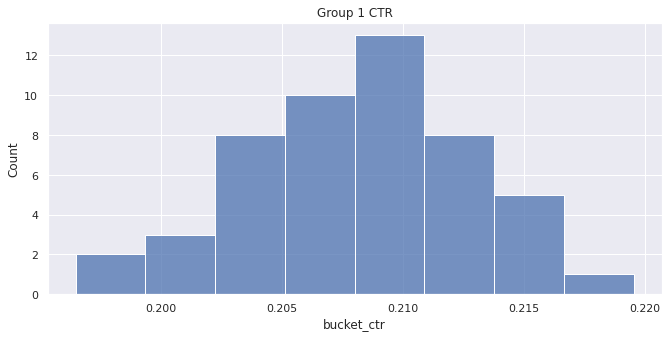

In [80]:
sns.histplot(df[df.exp_group == 1].bucket_ctr).set(title='Group 1 CTR')

[Text(0.5, 1.0, 'Group 2 CTR')]

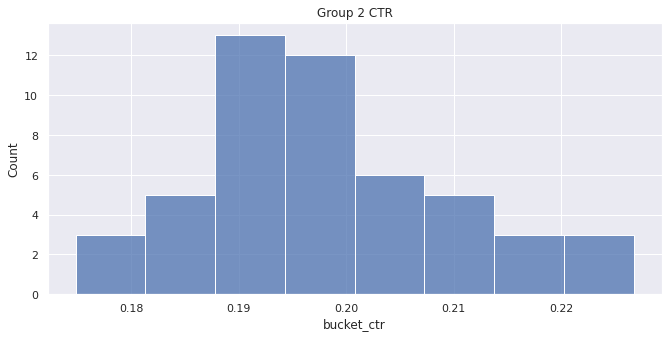

In [81]:
sns.histplot(df[df.exp_group == 2].bucket_ctr).set(title='Group 2 CTR')

### Comparison of 90% CTR

[Text(0.5, 1.0, 'Group 1 CTR9')]

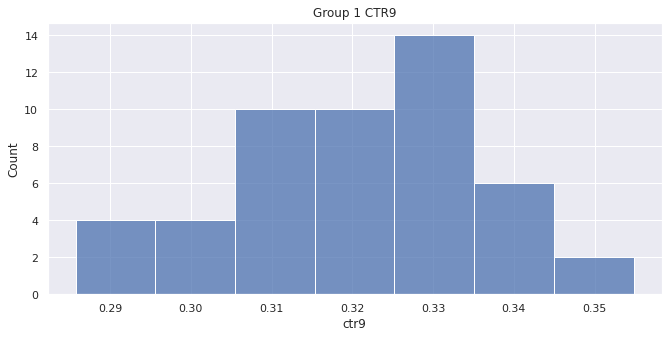

In [83]:
sns.histplot(df[df.exp_group == 1].ctr9).set(title='Group 1 CTR9')

[Text(0.5, 1.0, 'Group 2 CTR9')]

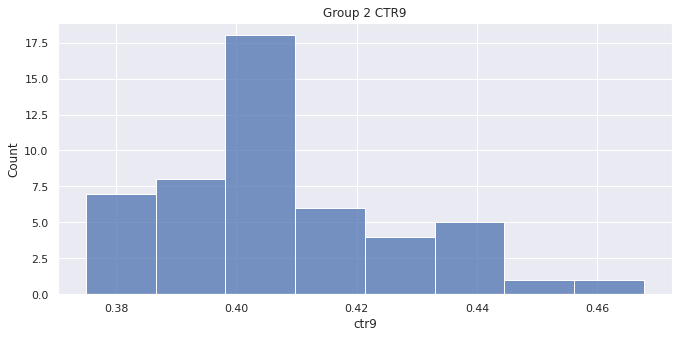

In [84]:
sns.histplot(df[df.exp_group == 2].ctr9).set(title='Group 2 CTR9')

In [44]:
stats.ttest_ind(df[df.exp_group == 1].ctr9, 
                df[df.exp_group == 2].ctr9, 
                   equal_var = False)

Ttest_indResult(statistic=-23.214341215937406, pvalue=1.2945537024964474e-40)

In [ ]:
It can be concluded that the differences between the groups are statistically significant.

#2 Analysis of the obtained results  
On the main chart, it is evident that there are differences, as the CTR (click-through rate) graph of the first group exhibits a unimodal (almost normal) distribution, while the CTR graph of the second group shows a bimodal distribution.
According to theory, applying the t-test in such a case yields unreliable results (although I performed it for illustrative purposes).
  
Based on the results, only the t-test indicated no statistically significant differences. However, the Mann-Whitney test, smoothed CTR, bootstrap and bucket conversion demonstrated the presence of differences.

#3 Why did this happen?  
The bimodal distribution in the test group may be caused by the presence of different subgroups of users. For example, it is possible that one subgroup of users prefers content with very high CTR, while another subgroup prefers content with lower CTR.

Thus, in the test group, there may be two differents populations of users, each with its own preferences and behaviors. This can result in two peaks in the CTR distribution. On the other hand, the control group may have fewer differences in user behavior, and therefore, the CTR distribution may be more closer to normal.

I also recommended to make sure that such bimodal distribution is not caused by data errors or outliers that could impact the A/B testing results. In such cases, additional data analysis may be required to identify and exclude outliers in order to obtain more accurate testing results.

#4 Algorithm Recommendations  
I would suggest conducting a more detailed research  of such ambiguous distribution, as the algorithm will undoubtedly behave differently with specific user groups. Therefore, it is necessary to thoroughly examine everything before rolling out the new algorithm.